Using matplotlib backend: module://matplotlib_inline.backend_inline


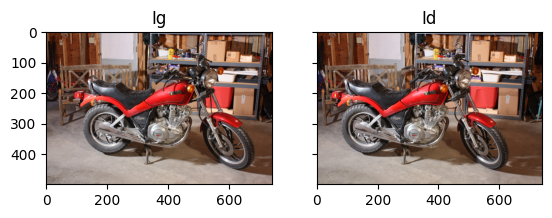

In [1]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv # librairie OpenCV
import matplotlib
import importlib
%matplotlib auto
# ouvrir les images en RGB et en niveaux de gris dans [[0 ;255]]
Ig, Id, gt = data.stereo_motorcycle()
Iggray = (rgb2gray(Ig)*255).astype('uint8')
Idgray = (rgb2gray(Id)*255).astype('uint8')
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(Ig)
axes[0].set_title("Ig")
axes[1].imshow(Id)
axes[1].set_title("Id")
plt.show()

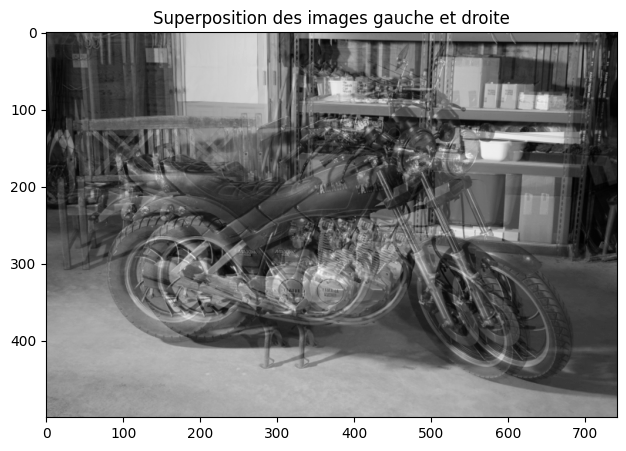

In [2]:
# Superposer les images pour observer le décalage
superposed_image = (Iggray / 2 + Idgray / 2).astype('uint8')

plt.figure(figsize=(10, 5))
plt.imshow(superposed_image, cmap='gray')
plt.title("Superposition des images gauche et droite")
plt.show()


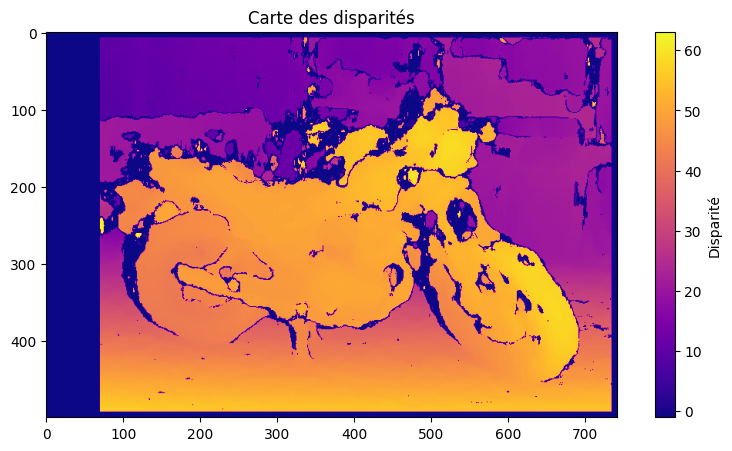

La disparité maximale estimée est : 63.0


In [3]:
# Utilisation de StereoBM pour estimer la disparité
maxdisp_initial = 64  # Estimation initiale
block_size = 15  # Taille du bloc de correspondance

# Création de l'objet StereoBM
stereo = cv.StereoBM_create(numDisparities=maxdisp_initial, blockSize=block_size)

# Calculer la carte des disparités
disparity_initial = stereo.compute(Iggray, Idgray)

# Disparités OpenCV sont multipliées par 16
disparity_corrected = disparity_initial / 16.0

# Afficher la carte des disparités avec l'échelle correcte
plt.figure(figsize=(10, 5))
plt.imshow(disparity_corrected, cmap='plasma')
plt.colorbar(label='Disparité')
plt.title("Carte des disparités")
plt.show()

# Déterminer la disparité maximale (en tenant compte de l'échelle correcte)
maxdisp = np.max(disparity_corrected)
print(f"La disparité maximale estimée est : {maxdisp}")


In [4]:
# attention avec ces implementations,
# numDisparities doit etre divisible par 16,
# les algos proposent une precision a 1/16 pixel ;
# en cherchant les disparites avec un pas de 1/16
# les disparites reelles s’en retrouvent *16
maxdisp = int(maxdisp)
numdisp = maxdisp if maxdisp%16==0 else ((maxdisp//16)+1)*16
# Block Matching
# attention, cette implementation ne fonctionne que
# pour des images en niveaux de gris
stereoBM = cv.StereoBM.create(numDisparities=numdisp, blockSize=15) # blockSize impair
dispBM = stereoBM.compute(Iggray,Idgray).astype(np.float32) / 16.0

In [5]:
# Semi Global Block Matching
# peut traiter des images RGB ou en niveaux de gris
stereoSGBM = cv.StereoSGBM.create(numDisparities=numdisp,blockSize=15) # impair
dispSGBM = stereoSGBM.compute(Ig,Id).astype(np.float32) / 16.0

In [6]:
# Stereo Quasi Dense,
# eparse puis densification par propagation
# ! ! necessite OpenCV >= 4.5 et opencv-contrib
# travaille en niveau de gris, meme avec des images RGB
# donne directement les disparites relles
# stereoQD = cv.stereo_QuasiDenseStereo.create(monoImgSize=Iggray.shape[::-1])
# stereoQD.process(Iggray,Idgray)
# dispQD = stereoQD.getDisparity()

In [7]:

import numpy as np

# Mask for valid points
mask = (disparity_corrected != -1) & (disparity_corrected != 0)

# Number of points without disparity
num_points_without_disparity = np.sum(disparity_corrected == -1)

# Display the number of points without disparity
print(f"Number of points without disparity: {num_points_without_disparity}")

# Apply the mask to the disparity map
disparity_corrected_masked = np.where(mask, disparity_corrected, np.nan)

Number of points without disparity: 83888


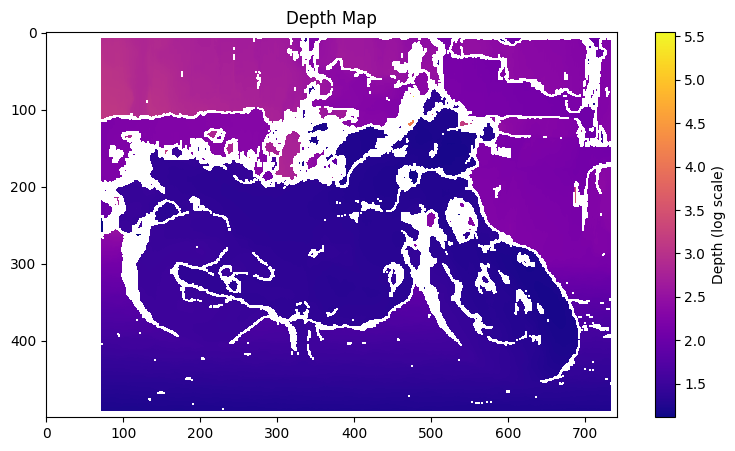

In [8]:

f = 994.978
b = 0.193001

# Calculate depth map
depth_map = f * b / disparity_corrected_masked

# Apply logarithm for better visualization
depth_map_log = np.log(depth_map)

# Display depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map_log, cmap='plasma')
plt.colorbar(label='Depth (log scale)')
plt.title("Depth Map")
plt.show()

In [9]:
def toggle(mode):
    """
    Fonction pour changer de mode d'affichage des images
        inline ==> Affichage directement dans le notebook
        tk ==> Affichage dans une fenêtre à part (permet de sélectionner des points sur l'image)
    """
    if mode == "tk":
        plt.close('all')
        matplotlib.use('TkAgg', force=True)
        importlib.reload(plt)
        plt.switch_backend('TkAgg')
    elif mode == "inline":
        plt.close('all')
        matplotlib.use('Agg', force=True)
        importlib.reload(plt)
        plt.switch_backend('Agg')
        %matplotlib inline

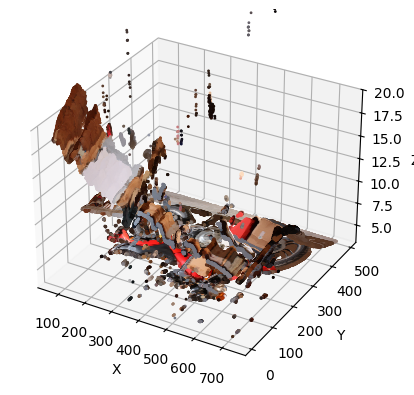

In [10]:
# toggle("tk")

xx, yy = np.meshgrid(np.arange(Ig.shape[1]), np.arange(Ig.shape[0]))
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[mask].flatten(), yy[mask].flatten(), depth_map[mask].flatten(), s=1, c=Ig[mask].reshape((-1,3))/255., depthshade=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([3.,20.]) # limite raisonnable de z pour la scene
plt.show()

In [11]:
# toggle("tk")

# xx, yy = np.meshgrid(np.arange(Ig.shape[1]), np.arange(Ig.shape[0]))
# fig = plt.figure()

# # Sous-échantillonnage des données en utilisant le slicing
# mask_subsampled = mask[::2, ::2]

# xx_subsampled = xx[::2, ::2]
# yy_subsampled = yy[::2, ::2]
# depth_map_subsampled = depth_map[::2, ::2]
# Ig_subsampled = Ig[::2, ::2]

# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xx_subsampled[mask_subsampled].flatten(), yy_subsampled[mask_subsampled].flatten(), depth_map_subsampled[mask_subsampled].flatten(), s=1, c=Ig_subsampled[mask_subsampled].reshape((-1,3))/255., depthshade=False)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_zlim([3.,20.]) # limite raisonnable de z pour la scene
# plt.show()

In [12]:
def compute_disparity_sad(Ig, Id, max_disp, N):
    height, width = Ig.shape
    disparity_map = np.zeros_like(Ig, dtype=np.float32)
    
    half_window = N // 2

    # Parcourir chaque pixel de l'image
    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            best_offset = 0
            min_sad = float('inf')
            
            # Comparer avec les décalages de -max_disp à 0
            for offset in range(-max_disp, 1):
                sad = 0
                
                # Calculer la SAD pour le bloc
                for v in range(-half_window, half_window + 1):
                    for u in range(-half_window, half_window + 1):
                        pixel_left = Ig[y + v, x + u]
                        pixel_right = Id[y + v, x + u + offset] if (x + u + offset) >= 0 else 0
                        sad += abs(int(pixel_left) - int(pixel_right))
                
                # Mettre à jour le meilleur décalage si une SAD plus petite est trouvée
                if sad < min_sad:
                    min_sad = sad
                    best_offset = offset
            
            # Stocker la disparité trouvée
            disparity_map[y, x] = -best_offset  # Disparité négative car décalage vers la gauche
    
    return disparity_map
